# Example working with OSM data and tc and river flood with climate change 

In [1]:
import matplotlib.pyplot as plt
import shapely
import contextily as ctx
from pathlib import Path
from climada.util.api_client import Client
from climada.engine import Impact
from climada_petals.entity.exposures.openstreetmap.osm_dataloader import OSMRaw, OSMApiQuery, OSMFileQuery
from climada import CONFIG
from climada_petals.entity.exposures.openstreetmap.osm_dataloader import DICT_CIS_OSM

DATA_DIR = CONFIG.exposures.openstreetmap.local_data.dir()

## OSM

In [2]:
OSMRaw().get_data_geofabrik('MOZ', file_format='pbf', save_path=DATA_DIR)
HNDFileQuery = OSMFileQuery(Path(DATA_DIR,'mozambique-latest.osm.pbf'))
gdf_health = HNDFileQuery.retrieve_cis('healthcare')
gdf_health = HNDFileQuery.retrieve_cis('healthcare')

extract points: 
extract multipol
/Users/szelie/python_projects/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:420: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(
extract points: 
extract multipol
/Users/szelie/python_projects/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:420: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(


In [3]:
gdf_health = HNDFileQuery.retrieve_cis('healthcare')

extract points: 
extract multipol
/Users/szelie/python_projects/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:420: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(


In [43]:
health_exposure.gdf['longitude'] = health_exposure.gdf['geometry'].centroid.x
health_exposure.gdf['latitude'] = health_exposure.gdf['geometry'].centroid.y

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_54142/886555781.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  health_exposure.gdf['longitude'] = health_exposure.gdf['geometry'].centroid.x
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_54142/886555781.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  health_exposure.gdf['latitude'] = health_exposure.gdf['geometry'].centroid.y


In [5]:
from climada.entity import Exposures
health_exposure = Exposures(gdf_health)
health_exposure.gdf.head()
health_exposure.gdf['value'] = 1 # we just set value of the hospitals to 1

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_54142/1590261066.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  health_exposure.gdf['geometry'] = health_exposure.gdf['geometry'].centroid


## TC

In [56]:
## getting TC from the API, based on the STORM model
from climada.util.api_client import Client

client = Client()
tc_present=client.get_hazard("tropical_cyclone", properties={'country_iso3alpha':'MOZ','track_model':'STORM', 'climate_scenario': 'historical'}, status='preliminary')
tc_future=client.get_hazard("tropical_cyclone", properties={'country_iso3alpha':'MOZ','track_model':'STORM','gcm':'CNRM-CM6-1-HR'}, status='preliminary')
#status will change to active in the future, so modify that in the query if it is not working

https://climada.ethz.ch/data-api/v1/dataset	climate_scenario=historical	country_iso3alpha=MOZ	data_type=tropical_cyclone	limit=100000	name=None	status=preliminary	track_model=STORM	version=None
https://climada.ethz.ch/data-api/v1/dataset	country_iso3alpha=MOZ	data_type=tropical_cyclone	gcm=CNRM-CM6-1-HR	limit=100000	name=None	status=preliminary	track_model=STORM	version=None


In [57]:
# getting some info on the data, you can see that I took one global climate model (gcm) above for the future climate (CNRM-CM6-1-HR), but there are multiple available. Ideally we should consider them all, but
# you can start with one
client.list_dataset_infos("tropical_cyclone", properties={'country_iso3alpha':'MOZ','track_model':'STORM'}, status='preliminary')

https://climada.ethz.ch/data-api/v1/dataset	country_iso3alpha=MOZ	data_type=tropical_cyclone	limit=100000	name=None	status=preliminary	track_model=STORM	version=None


[DatasetInfo(uuid='1ed0c383-36a2-458a-af14-8b9c529a3df4', data_type=DataTypeShortInfo(data_type='tropical_cyclone', data_type_group='hazard'), name='TC_MOZ_0300as_STORM', version='v1', status='preliminary', properties={'res_arcsec': '150', 'climate_scenario': 'historical', 'climada_version': 'v3.1.2', 'spatial_coverage': 'country', 'track_model': 'STORM', 'tracks_year_range': '1979_2014', 'country_iso3alpha': 'MOZ', 'country_name': 'Mozambique', 'country_iso3num': '508', 'date_creation': '2022-9-7'}, files=[FileInfo(uuid='1ed0c383-36a2-458a-af14-8b9c529a3df4', url='https://data.iac.ethz.ch/climada/1ed0c383-36a2-458a-af14-8b9c529a3df4/TC_MOZ_0300as_STORM.hdf5', file_name='TC_MOZ_0300as_STORM.hdf5', file_format='hdf5', file_size=234655068, check_sum='md5:ff0b40426e276ff06ac14a54f6599915')], doi=None, description='1000 years of past climate tropical cyclone hazard for the years 1979–2014 based on the STORM model tracks. The tracks based on which the hazard are generated can be found at ht

In [11]:
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone
impf_TC = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet() # getting the calibrated impact functions

In [28]:
# we put the right impact function for the right exposure points, based on their country
# this is mainly if you had multiple countries, you could make it simpler if you know you are just considering 1 country
import numpy as np
import pycountry


health_exposure.gdf['region_id'] = pycountry.countries.lookup('MOZ').numeric
def get_impf_id(cnt):
    for basin, iso_list in ImpfSetTropCyclone.get_countries_per_region()[2].items():
        for iso in iso_list:
            if iso == cnt:
                return basin, ImpfSetTropCyclone.get_countries_per_region()[1][basin]
health_exposure.gdf['impf_TC'] = 1

for cnt in np.unique(health_exposure.gdf.region_id):
    health_exposure.gdf.loc[health_exposure.gdf['region_id']==cnt, 'impf_TC'] = get_impf_id(int(cnt))[1]

In [47]:
# impact calculation,"old way", there is a better way to do it if you are on develop, but this works anyways.
# you can have a look at the tutorials if you want to update it
imp_hospitals_present = Impact()
imp_hospitals_present.calc(health_exposure, impf_TC, tc_present, save_mat=True)


2022-11-04 11:33:45,740 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


In [49]:
imp_hospitals_future = Impact()
imp_hospitals_future.calc(health_exposure, impf_TC, tc_future, save_mat=True)



2022-11-04 11:34:04,774 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

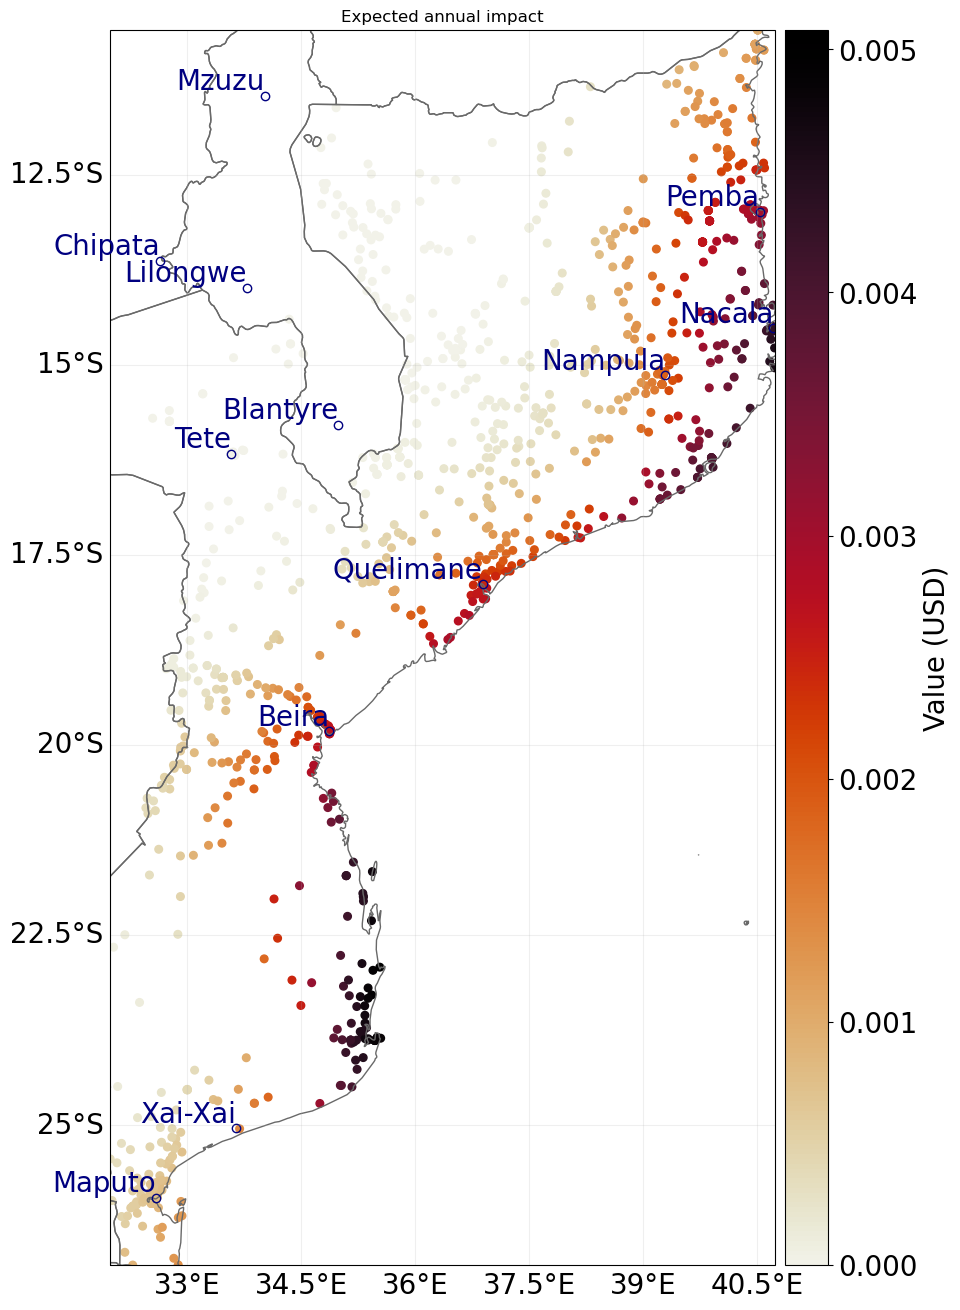

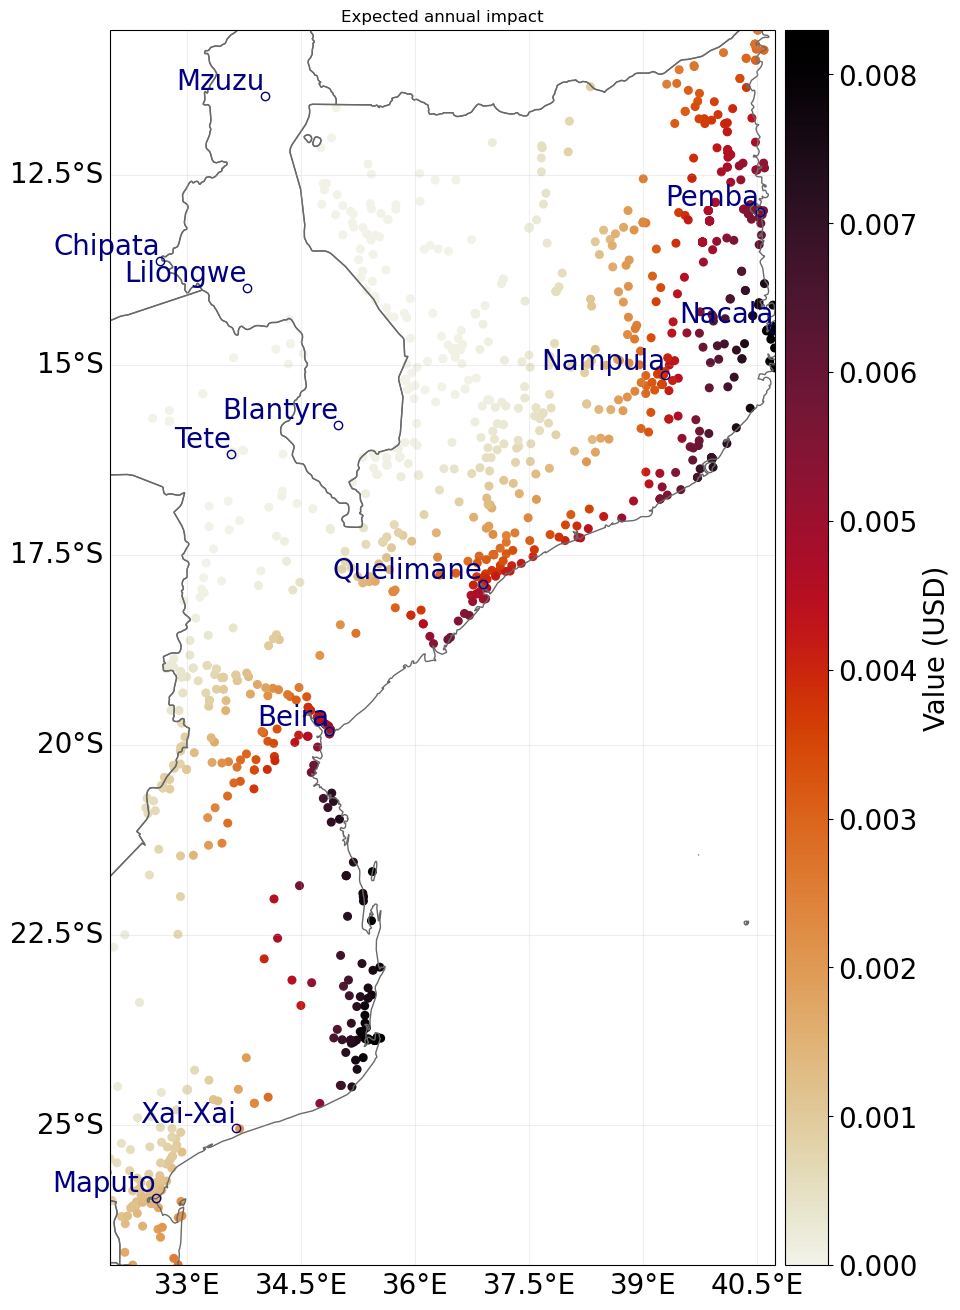

In [50]:
imp_hospitals_present.plot_scatter_eai_exposure(s=30)
imp_hospitals_future.plot_scatter_eai_exposure(s=30)

## River floods

In [66]:
## getting TC from the API, based on the STORM model
# you will have to check the time ranges of each hazard if you want to put them together
from climada.util.api_client import Client

client = Client()
rf_present=client.get_hazard("river_flood", properties={'country_iso3alpha':'MOZ', 'climate_scenario': 'historical'}, status='active')
rf_future=client.get_hazard("river_flood", properties={'country_iso3alpha':'MOZ','climate_scenario':'rcp85', 'year_range':'2030_2050'}, status='active')
#status will change to active in the future, so modify that in the query if it is not working

https://climada.ethz.ch/data-api/v1/dataset	climate_scenario=historical	country_iso3alpha=MOZ	data_type=river_flood	limit=100000	name=None	status=active	version=None
https://climada.ethz.ch/data-api/v1/dataset	climate_scenario=rcp85	country_iso3alpha=MOZ	data_type=river_flood	limit=100000	name=None	status=active	version=None	year_range=2030_2050


In [94]:
from climada_petals.entity.impact_funcs.river_flood import ImpfRiverFlood, flood_imp_func_set, RIVER_FLOOD_REGIONS_CSV
import pandas as pd

health_exposure.gdf['impf_RF'] = 1
regions_df = pd.read_csv(RIVER_FLOOD_REGIONS_CSV)

for c in regions_df['ISO']:
    country=pycountry.countries.get(alpha_3=c)
    if country is None:
        continue
    country_numeric = int(country.numeric)
    if len(health_exposure.gdf.loc[health_exposure.gdf['region_id']==country_numeric, 'impf_RF'])>0:
        health_exposure.gdf.loc[health_exposure.gdf['region_id']==country_numeric, 'impf_RF'] = int(regions_df[regions_df['ISO']== country]['impf_RF'])
impf_set_flood = flood_imp_func_set()

In [99]:
imp_hospitals_present_rf = Impact()
imp_hospitals_present_rf.calc(health_exposure, impf_set_flood, rf_future, save_mat=True)

imp_hospitals_future_rf = Impact()
imp_hospitals_future_rf.calc(health_exposure, impf_set_flood, rf_future, save_mat=True)

2022-11-04 12:11:17,486 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-04 12:11:17,552 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

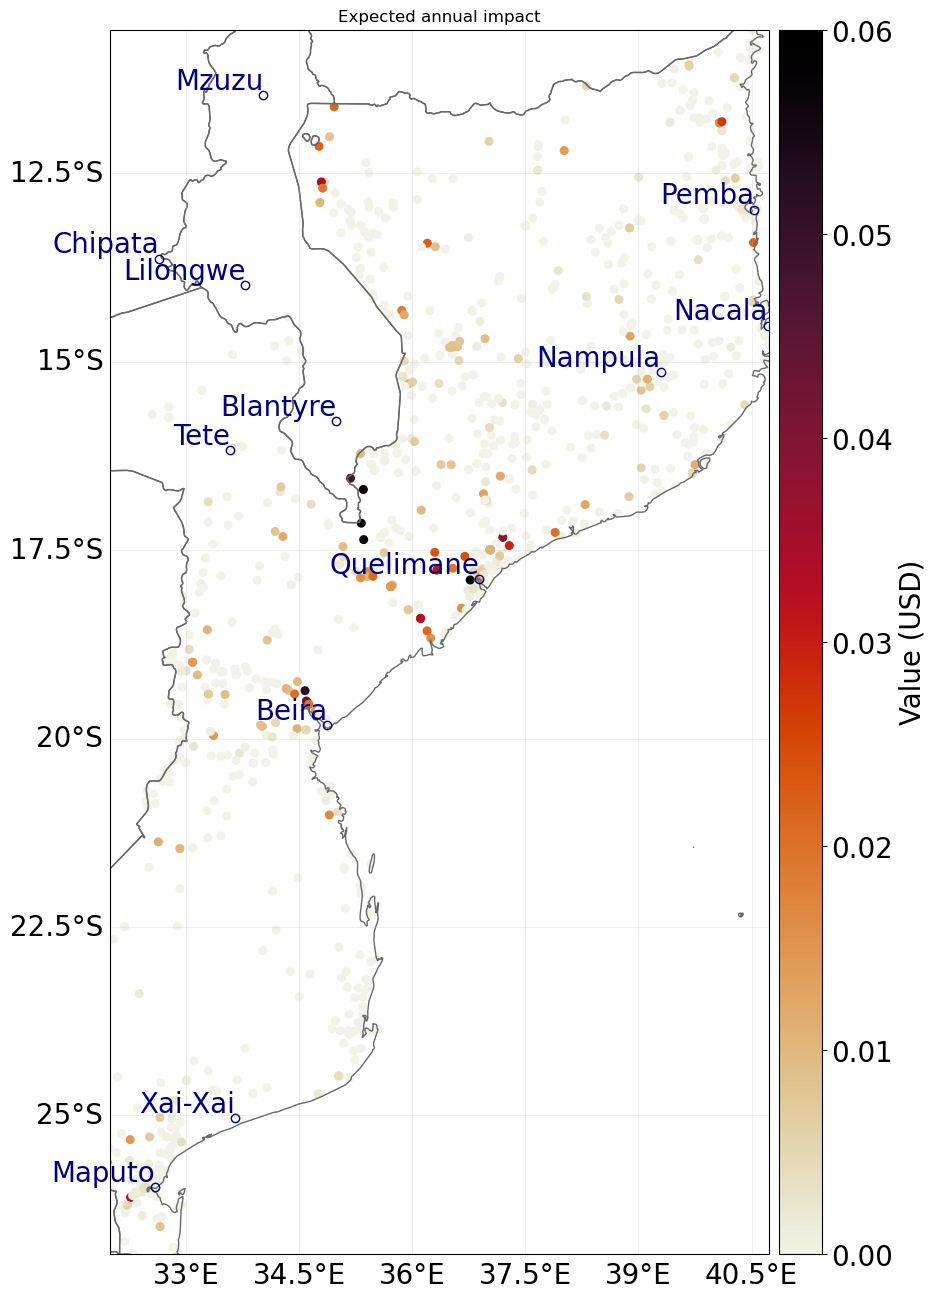

In [96]:
imp_hospitals_present_rf.plot_scatter_eai_exposure(s=30)

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

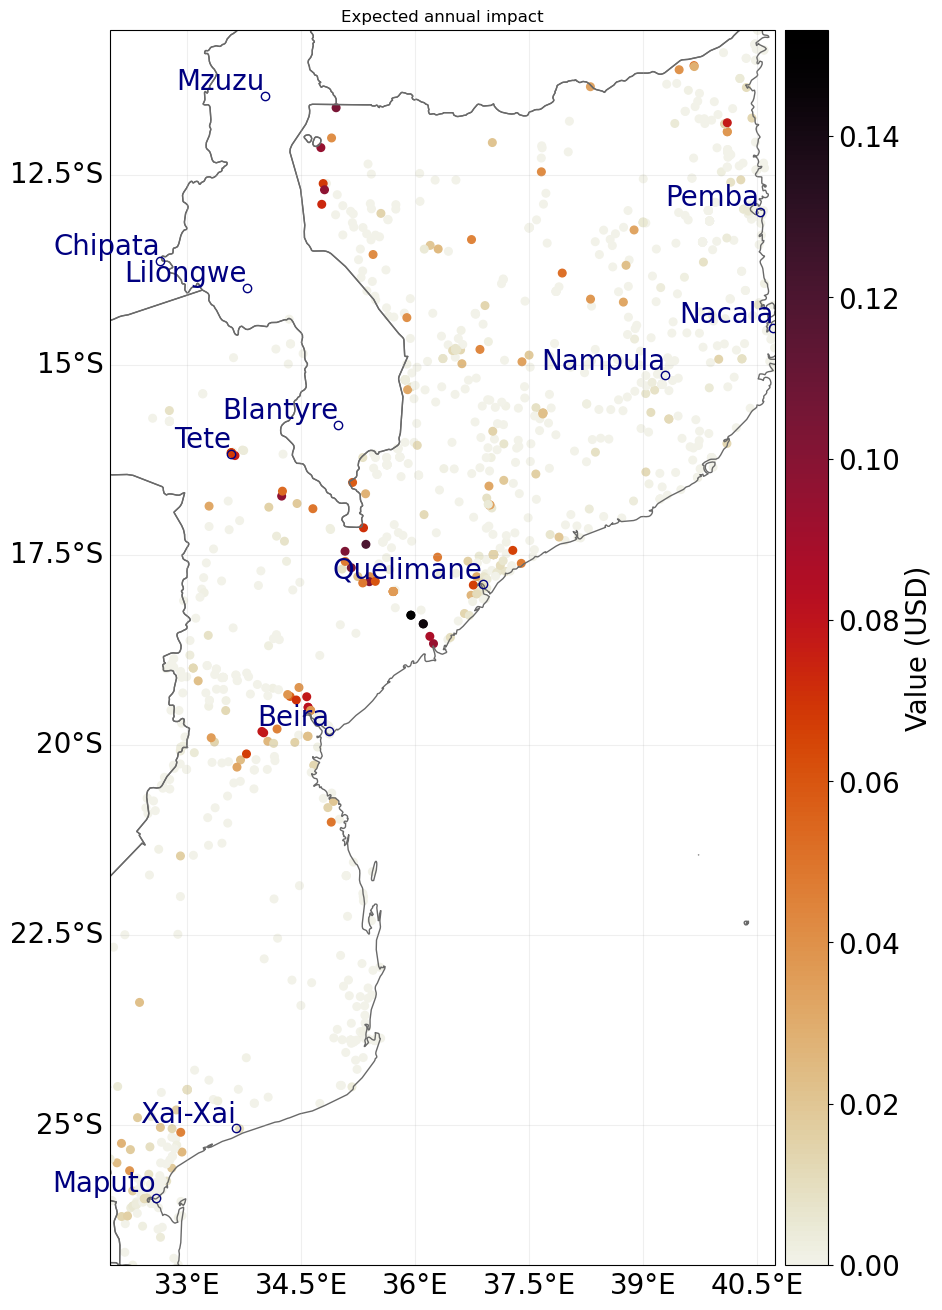

In [100]:
imp_hospitals_future_rf.plot_scatter_eai_exposure(s=30)